In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import json
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.utils import mask_to_categorical
from stardist.plot import render_label

import matplotlib.colors as mcolors
import copy

np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab20


def cus_plot_img_label(X_main, lbl, cls_dict):
    X_modified = X_main.copy()  # Create a copy of the input image

    c = mask_to_categorical(lbl, n_classes=4, classes=cls_dict)
    res = np.argmax(c, axis=-1).astype(np.uint16)

    colors = {
        1: (59 / 255, 154 / 255, 251 / 255),   # Blue for mask value 1
        2: (0 / 255, 255 / 255, 61 / 255),     # Green for mask value 2
        3: (250 / 255, 220 / 255, 57 / 255),   # Yellow for mask value 3
        4: (255 / 255, 0 / 255, 23 / 255)      # Red for mask value 4
    }

    h, w = res.shape[:2]
    mask_values = np.unique(res)

    for mask_value in mask_values:
        if mask_value in colors:
            color = colors[mask_value]
            mask = res == mask_value
            X_modified[mask] = color

    return X_modified


def plot_all(img, lbl, cls_dict, img_title="ROI", lbl_title="Ground truth", cls_title="Ground truth by Classs", font_size=18, **kwargs):
    
    plot_img=cus_plot_img_label(img,lbl,cls_dict)
    
    
    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title, fontsize=font_size)    
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title, fontsize=font_size)
    ac.imshow(plot_img)
    ac.set_title(cls_title, fontsize=font_size)
    plt.tight_layout()    
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac

C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
transport.py (219): Blowfish has been deprecated


In [2]:
# set the number of object classes
n_classes = 4

In [3]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm

def make_image(folder_paths, height, width):
    
    new_image = np.zeros((height, width), dtype=np.uint8)
    
    my_dict = {}

    class_name_reco = {
        'Blue': 1,
        'Green': 2,
        'Yellow': 3,
        'Red': 4
    }
    for i, path in enumerate(folder_paths):
        
        class_name= path.split('\\')[-1].split('_')[-2]
        reference_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        reference_image = cv2.resize(reference_image, (width, height))
        new_image[reference_image > 0 ] = i+1
        my_dict[i+1] = class_name_reco[class_name]
        
        
    return new_image, my_dict


    
X_test=[]
Y_test=[]
C_test=[]
for path in tqdm(os.listdir(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing')):
    roi=io.imread(glob.glob(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing/'+path+'/image/*.png')[0])
    height, width, _ = roi.shape
    #height, width, _ = [256,256,3]
    roi = transform.resize(roi, (height, width))
    
    folder_paths= glob.glob(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing/'+path+'/color_masks/*.png')
    one_image, my_dict=make_image(folder_paths, height, width)
    
    X_test.append(roi)
    Y_test.append(one_image)
    C_test.append(my_dict)

100%|██████████| 44/44 [00:07<00:00,  6.00it/s]


(<Axes: title={'center': 'ROI'}>,
 <Axes: title={'center': 'Ground truth'}>,
 <Axes: title={'center': 'Ground truth by Classs'}>)

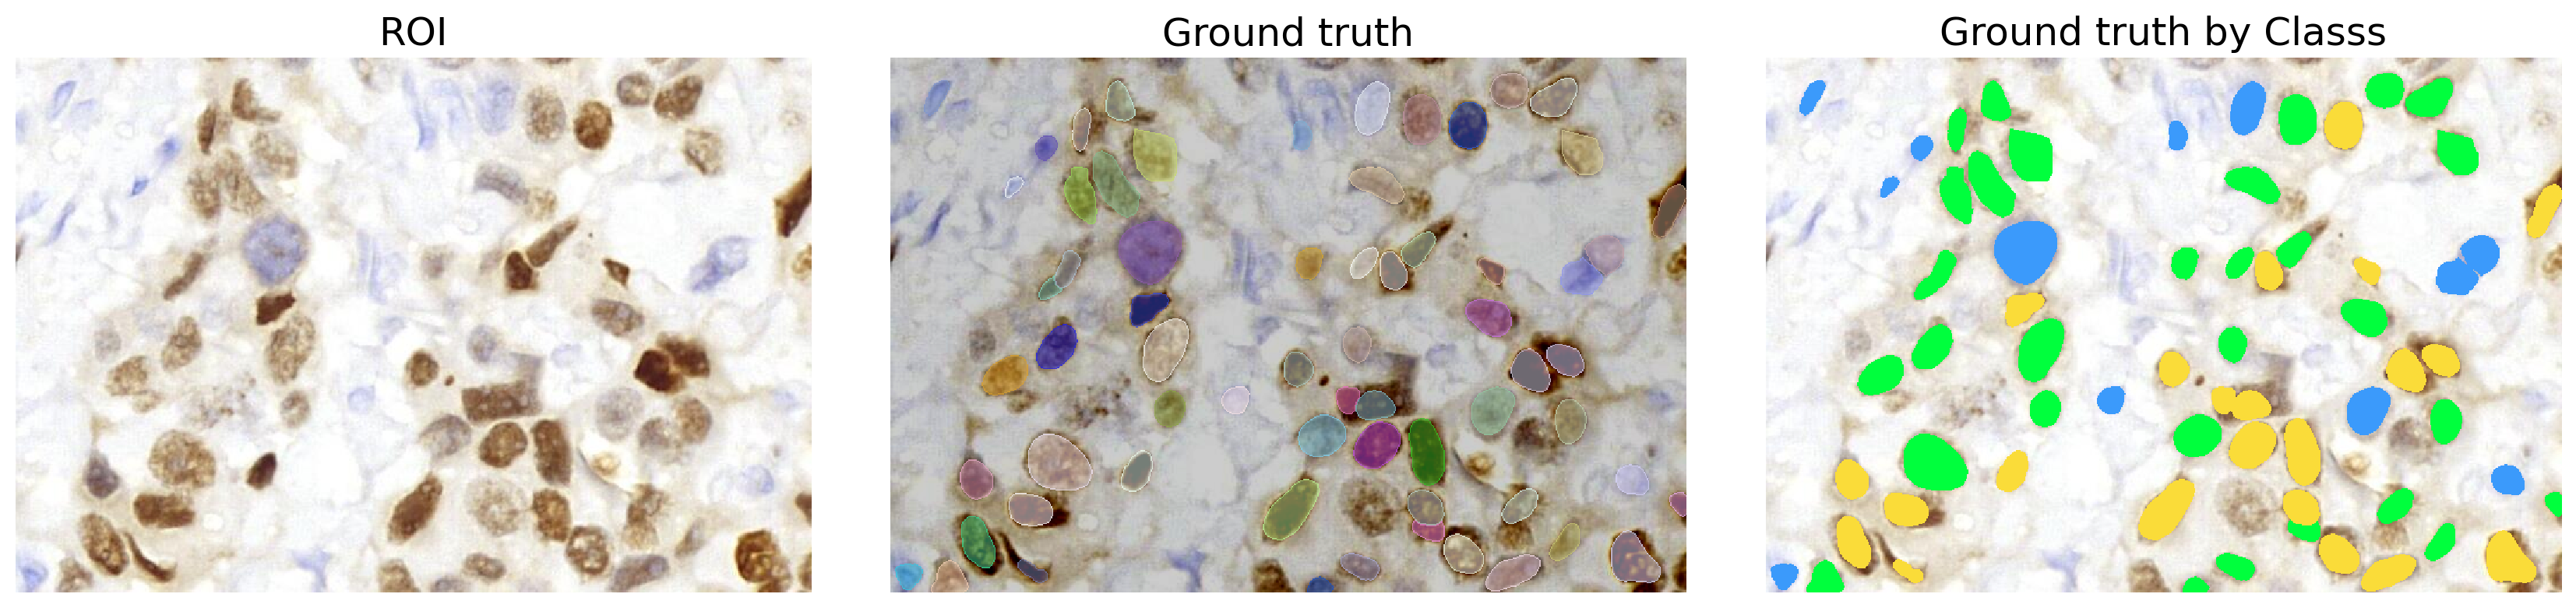

In [4]:
valuesss=24
plot_all(X_test[valuesss],Y_test[valuesss], C_test[valuesss])

In [5]:
model = StarDist2D(None, name='vggunet_multiclass_ai4dp_none', basedir='models')

Jahid-GPU
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   896         ['input[0][0]']                  
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   9248        ['conv2d[0][0]']                 
                                32)                                                 

                                                                                                  
 features (Conv2D)              (None, None, None,   36992       ['up_level_0_no_2[0][0]']        
                                128)                                                              
                                                                                                  
 features_class (Conv2D)        (None, None, None,   36992       ['up_level_0_no_2[0][0]']        
                                128)                                                              
                                                                                                  
 prob (Conv2D)                  (None, None, None,   129         ['features[0][0]']               
                                1)                                                                
                                                                                                  
 dist (Con

In [6]:
model.optimize_thresholds(X_test, Y_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 20ms/step


NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:44<00:14,  2.97s/it, 0.596 -> 0.755]


Using optimized values: prob_thresh=0.596393, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.5963929478174308, 'nms': 0.3}

In [7]:
i = 42
label, res = model.predict_instances(X_test[i], n_tiles=model._guess_n_tiles(X_test[i]))


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step



 50%|█████     | 1/2 [00:00<00:00,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


In [8]:
# the class object ids are stored in the 'results' dict and correspond to the label ids in increasing order 
def class_from_res(res):
    cls_dict = dict((i+1,c) for i,c in enumerate(res['class_id']))
    return cls_dict


(<Axes: title={'center': 'ROI'}>,
 <Axes: title={'center': 'Predict'}>,
 <Axes: title={'center': 'Predict by Classs'}>)

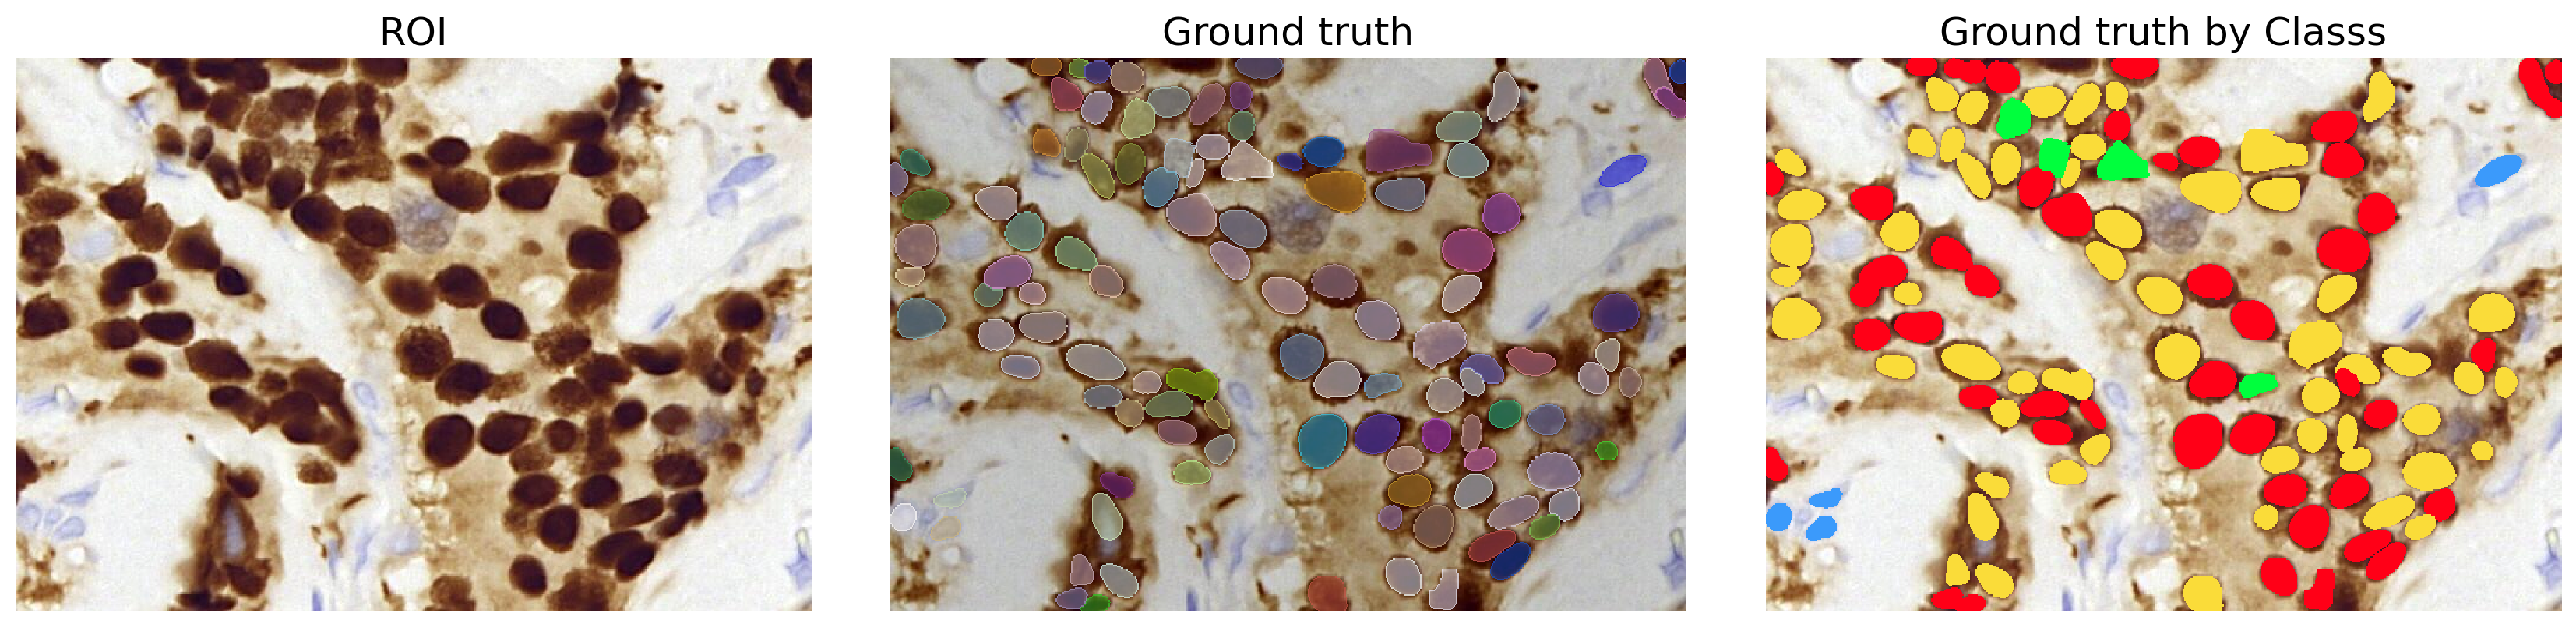

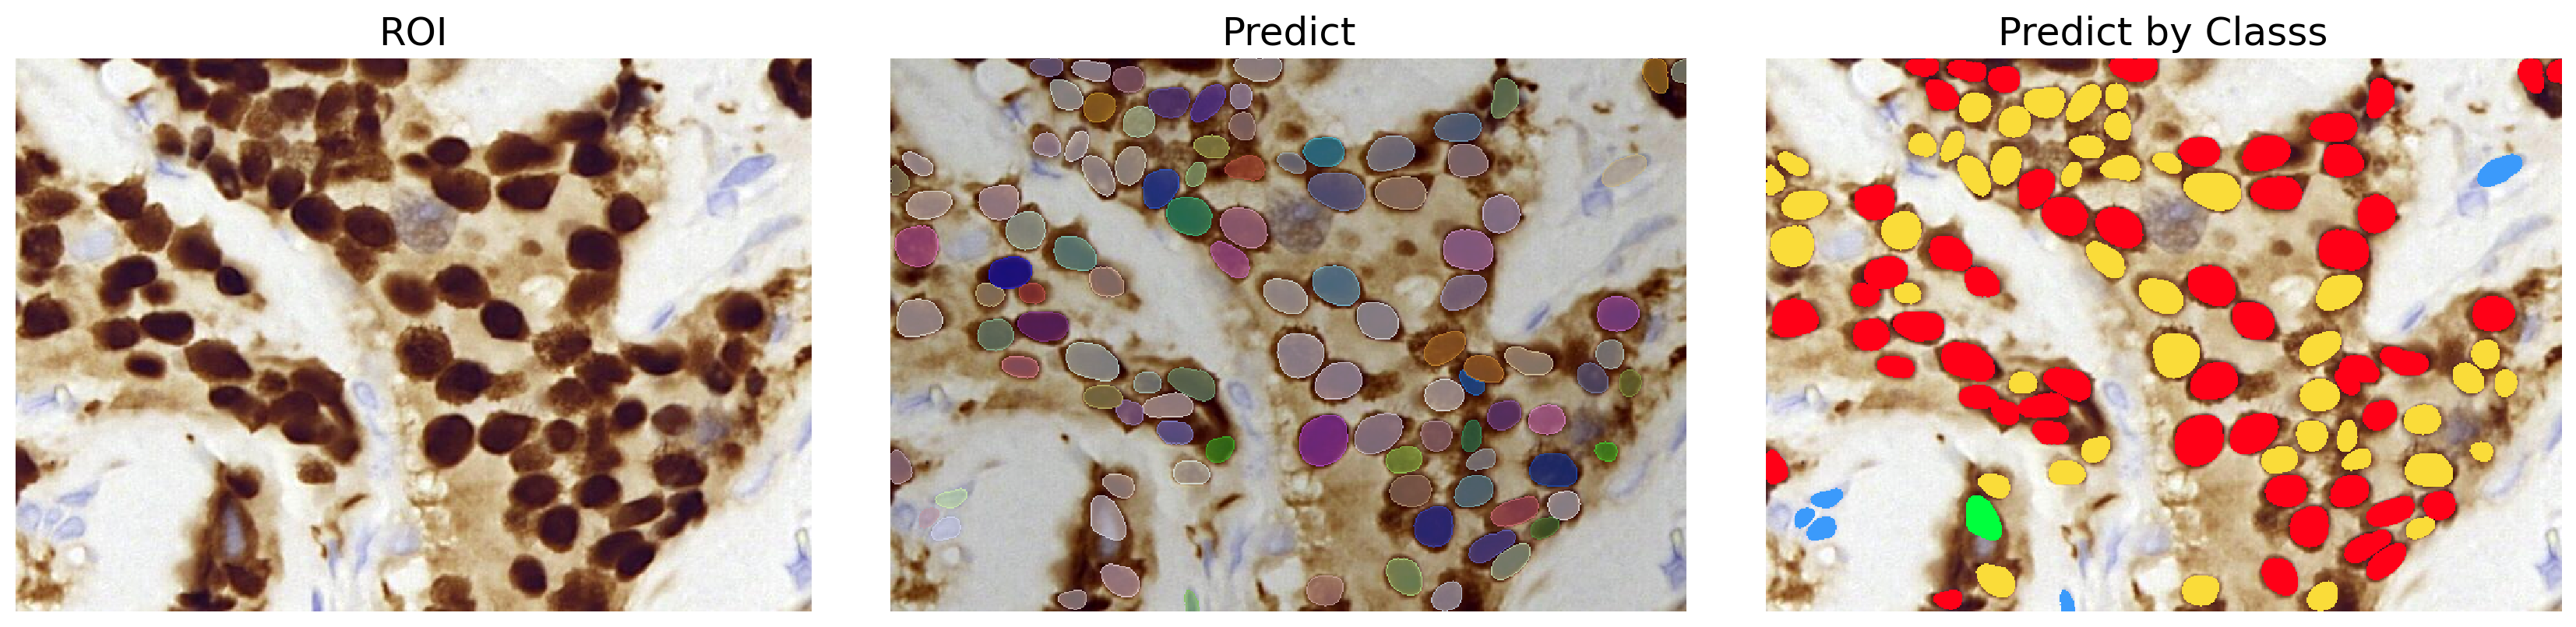

In [9]:
plot_all(X_test[i], Y_test[i], C_test[i],            lbl_title="Ground truth", cls_title="Ground truth by Classs")
plot_all(X_test[i], label,    class_from_res(res), lbl_title="Predict", cls_title="Predict by Classs")

In [10]:
Y_test_pred, res_test_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
              for x in tqdm(X_test[:])]))


  0%|          | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step



  2%|▏         | 1/44 [00:00<00:16,  2.58it/s]

1/1 [==============================] - 0s 18ms/step



  5%|▍         | 2/44 [00:00<00:15,  2.77it/s]

1/1 [==============================] - 0s 18ms/step



  7%|▋         | 3/44 [00:01<00:14,  2.74it/s]

1/1 [==============================] - 0s 22ms/step



  9%|▉         | 4/44 [00:01<00:14,  2.80it/s]

1/1 [==============================] - 0s 19ms/step



 11%|█▏        | 5/44 [00:01<00:13,  2.97it/s]

1/1 [==============================] - 0s 18ms/step



 14%|█▎        | 6/44 [00:02<00:11,  3.23it/s]

1/1 [==============================] - 0s 18ms/step



 16%|█▌        | 7/44 [00:02<00:10,  3.56it/s]

1/1 [==============================] - 0s 18ms/step



 18%|█▊        | 8/44 [00:02<00:09,  3.69it/s]

1/1 [==============================] - 0s 17ms/step



 20%|██        | 9/44 [00:02<00:10,  3.38it/s]

1/1 [==============================] - 0s 19ms/step



 23%|██▎       | 10/44 [00:03<00:09,  3.43it/s]

1/1 [==============================] - 0s 17ms/step



 25%|██▌       | 11/44 [00:03<00:09,  3.42it/s]

1/1 [==============================] - 0s 17ms/step



 27%|██▋       | 12/44 [00:03<00:08,  3.71it/s]

1/1 [==============================] - 0s 20ms/step



 30%|██▉       | 13/44 [00:04<00:09,  3.21it/s]

1/1 [==============================] - 0s 18ms/step



 32%|███▏      | 14/44 [00:04<00:09,  3.01it/s]

1/1 [==============================] - 0s 18ms/step



 34%|███▍      | 15/44 [00:04<00:09,  3.12it/s]

1/1 [==============================] - 0s 20ms/step



 36%|███▋      | 16/44 [00:05<00:09,  2.99it/s]

1/1 [==============================] - 0s 20ms/step



 39%|███▊      | 17/44 [00:05<00:09,  2.80it/s]

1/1 [==============================] - 0s 19ms/step



 41%|████      | 18/44 [00:05<00:09,  2.68it/s]

1/1 [==============================] - 0s 18ms/step



 43%|████▎     | 19/44 [00:06<00:08,  2.87it/s]

1/1 [==============================] - 0s 19ms/step



 45%|████▌     | 20/44 [00:06<00:08,  2.68it/s]

1/1 [==============================] - 0s 18ms/step



 48%|████▊     | 21/44 [00:07<00:08,  2.62it/s]

1/1 [==============================] - 0s 19ms/step



 50%|█████     | 22/44 [00:07<00:08,  2.74it/s]

1/1 [==============================] - 0s 17ms/step



 52%|█████▏    | 23/44 [00:07<00:08,  2.47it/s]

1/1 [==============================] - 0s 18ms/step



 55%|█████▍    | 24/44 [00:08<00:08,  2.31it/s]

1/1 [==============================] - 0s 17ms/step



 57%|█████▋    | 25/44 [00:08<00:07,  2.70it/s]

1/1 [==============================] - 0s 20ms/step



 59%|█████▉    | 26/44 [00:08<00:06,  2.81it/s]

1/1 [==============================] - 0s 18ms/step



 61%|██████▏   | 27/44 [00:09<00:06,  2.71it/s]

1/1 [==============================] - 0s 18ms/step



 64%|██████▎   | 28/44 [00:09<00:05,  3.16it/s]

1/1 [==============================] - 0s 19ms/step



 66%|██████▌   | 29/44 [00:09<00:04,  3.11it/s]

1/1 [==============================] - 0s 18ms/step



 68%|██████▊   | 30/44 [00:10<00:04,  3.44it/s]

1/1 [==============================] - 0s 18ms/step



 70%|███████   | 31/44 [00:10<00:03,  3.59it/s]

1/1 [==============================] - 0s 18ms/step



 73%|███████▎  | 32/44 [00:10<00:03,  3.16it/s]

1/1 [==============================] - 0s 17ms/step



 75%|███████▌  | 33/44 [00:10<00:03,  3.41it/s]

1/1 [==============================] - 0s 18ms/step



 77%|███████▋  | 34/44 [00:11<00:03,  3.20it/s]

1/1 [==============================] - 0s 18ms/step



 80%|███████▉  | 35/44 [00:11<00:03,  2.90it/s]

1/1 [==============================] - 0s 17ms/step



 82%|████████▏ | 36/44 [00:11<00:02,  3.12it/s]

1/1 [==============================] - 0s 18ms/step



 84%|████████▍ | 37/44 [00:12<00:02,  2.90it/s]

1/1 [==============================] - 0s 18ms/step



 86%|████████▋ | 38/44 [00:12<00:01,  3.04it/s]

1/1 [==============================] - 0s 17ms/step



 89%|████████▊ | 39/44 [00:12<00:01,  3.04it/s]

1/1 [==============================] - 0s 18ms/step



 91%|█████████ | 40/44 [00:13<00:01,  3.29it/s]

1/1 [==============================] - 0s 17ms/step



 93%|█████████▎| 41/44 [00:13<00:00,  3.50it/s]

1/1 [==============================] - 0s 18ms/step



 95%|█████████▌| 42/44 [00:13<00:00,  3.45it/s]

1/1 [==============================] - 0s 18ms/step



 98%|█████████▊| 43/44 [00:14<00:00,  3.56it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 44/44 [00:14<00:00,  3.04it/s]


In [11]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_test, Y_test_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:02<00:00,  3.03it/s]


In [12]:
stats[taus.index(0.3)]

DatasetMatching(criterion='iou', thresh=0.3, fp=530, tp=3900, fn=365, precision=0.8803611738148984, recall=0.9144196951934349, accuracy=0.8133472367049009, f1=0.8970672800460034, n_true=4265, n_pred=4430, mean_true_score=0.7630607600508373, mean_matched_score=0.83447542092739, panoptic_quality=0.7485805961165777, by_image=False)

In [ ]:
for i in range(44):
    plot_all(X_test[i],Y_test[i],      C_test[i],                        lbl_title="Ground truth", cls_title="Ground truth by Classs")
    plot_all(X_test[i],Y_test_pred[i], class_from_res(res_test_pred[i]), lbl_title="Predict", cls_title="Predict by Classs");

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_f1=[]
all_recall=[]
all_pre=[]

for i in range(44):
    true_value = []
    predic_value = []
    for key, value in C_test[i].items():
        highlighted_image = np.zeros_like(Y_test[i])  # Create an image filled with zeros
        highlighted_image[Y_test[i] == key] = 1  # Set the pixels with the specific value to the value itself



        highlighted_image_2 = highlighted_image*Y_test_pred[i]
        flattened_matrix = highlighted_image_2.flatten()
        undesired_value = 0
        filtered_values = flattened_matrix[flattened_matrix != undesired_value]
        unique_values, counts = np.unique(filtered_values, return_counts=True)
        #highlighted_image_2[np.logical_and(highlighted_image, Y_test_pred[i]) == True] = value

        if len(counts) != 0:
            max_index = np.argmax(counts)

            true_value.append(value)
            predic_value.append(class_from_res(res_test_pred[i]).get(unique_values[max_index]))
            
    # Calculate precision, recall, and F1 score
    precision = precision_score(true_value, predic_value, average='macro')
    recall = recall_score(true_value, predic_value, average='macro')
    f1 = f1_score(true_value, predic_value, average='macro')
    
    all_f1.append(f1)
    all_pre.append(precision)
    all_recall.append(recall)

    print(f"Image: {i}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n\n")

Image: 0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 1
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 2
Precision: 0.6666666666666666
Recall: 0.9926470588235294
F1 Score: 0.7462962962962962


Image: 3
Precision: 1.0
Recall: 1.0
F1 Score: 1.0




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 4
Precision: 0.5
Recall: 0.4975124378109453
F1 Score: 0.49875311720698257


Image: 5
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 6
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 7
Precision: 0.902046783625731
Recall: 0.7968031968031967
F1 Score: 0.8248826291079813


Image: 8
Precision: 1.0
Recall: 1.0
F1 Score: 1.0




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 9
Precision: 0.5
Recall: 0.4915254237288136
F1 Score: 0.49572649572649574


Image: 10
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 11
Precision: 0.9333333333333333
Recall: 0.88
F1 Score: 0.8961038961038961


Image: 12
Precision: 1.0
Recall: 1.0
F1 Score: 1.0




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 13
Precision: 0.5901771336553945
Recall: 0.5711631363805276
F1 Score: 0.5744619799139168


Image: 14
Precision: 0.8477130977130978
Recall: 0.787001287001287
F1 Score: 0.8030355694589272


Image: 15
Precision: 0.5
Recall: 0.4880952380952381
F1 Score: 0.4939759036144578


Image: 16
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 17
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 18
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 19
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 20
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 21
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 22
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 23
Precision: 0.6569444444444444
Recall: 0.657735321528425
F1 Score: 0.6572440213605759


Image: 24
Precision: 0.8986175115207374
Recall: 0.8746081504702196
F1 Score: 0.8854189737910668




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Image: 25
Precision: 0.6821546052631579
Recall: 0.6778846153846154
F1 Score: 0.6748195669607057


Image: 26
Precision: 0.9016681299385425
Recall: 0.9156589147286821
F1 Score: 0.9057037259015083




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 27
Precision: 0.6666666666666666
Recall: 0.6587301587301587
F1 Score: 0.6626506024096385


Image: 28
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 29
Precision: 0.936372269705603
Recall: 0.9484126984126983
F1 Score: 0.9418181818181818


Image: 30
Precision: 0.9859154929577465
Recall: 0.8571428571428572
F1 Score: 0.9095238095238095


Image: 31
Precision: 0.6471003134796238
Recall: 0.6392780992994213
F1 Score: 0.6415




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 32
Precision: 0.588
Recall: 0.5624234256309728
F1 Score: 0.5555067279850111


Image: 33
Precision: 0.48484848484848486
Recall: 0.48484848484848486
F1 Score: 0.48484848484848486


Image: 34
Precision: 0.8334097967250141
Recall: 0.8548444976076555
F1 Score: 0.8421219585012688


Image: 35
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 36
Precision: 0.7726579520697168
Recall: 0.7426843317972351
F1 Score: 0.7514008620689655


Image: 37
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 38
Precision: 0.8729166666666667
Recall: 0.8729166666666667
F1 Score: 0.8729166666666667


Image: 39
Precision: 0.9793814432989691
Recall: 0.6
F1 Score: 0.656140350877193


Image: 40
Precision: 0.8007936507936507
Recall: 0.8097222222222222
F1 Score: 0.8029914529914529




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Image: 41
Precision: 0.4936708860759494
Recall: 0.5
F1 Score: 0.4968152866242039


Image: 42
Precision: 0.6440217391304348
Recall: 0.6526495383380169
F1 Score: 0.645802687064823


Image: 43
Precision: 0.6116071428571428
Recall: 0.6287878787878788
F1 Score: 0.6192307692307693




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [16]:
import statistics

print(f"Precision: {statistics.mean(all_pre)}")
print(f"Recall: {statistics.mean(all_recall)}")
print(f"F1 Score: {statistics.mean(all_f1)}\n\n")

Precision: 0.8385610048053812
Recall: 0.8282517190963579
F1 Score: 0.8259020458193927




In [17]:
# --------------------------Optimised for Speed
def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from 
    over-penalisation similar to DICE2.

    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.

    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()

    aji_score = overall_inter / overall_union
    return aji_score


all_aji_score=[]
for m in range(44):
    aji_score = get_fast_aji(Y_test[m],Y_test_pred[m])
    all_aji_score.append(aji_score)

print(all_aji_score)
print('Total AJI: ', (sum(all_aji_score) / len(all_aji_score)))

[0.6843527090605555, 0.6835756926373795, 0.7414233292764392, 0.6835250756567715, 0.6654546837561328, 0.613758371525864, 0.8536036803544045, 0.6327121838905967, 0.6620435826656792, 0.702860998397541, 0.829353998951827, 0.7399002416506599, 0.7866644315817499, 0.5297925883833259, 0.7820519169249968, 0.7438084562300767, 0.6731211764045575, 0.7437253183287622, 0.6969014138072012, 0.7698344188966492, 0.8180826649094504, 0.7696619964108727, 0.7730502543846468, 0.7048369532337104, 0.6561883629191322, 0.5554946676221388, 0.7632301157714295, 0.7094666496403184, 0.672771168538255, 0.7495817205643651, 0.7574685317262859, 0.7129799540080369, 0.5951753412495838, 0.5670704914945703, 0.7468068302513685, 0.719078098819899, 0.6769936235983893, 0.6943259094717562, 0.7729433300516859, 0.7184497885501483, 0.6118986704693201, 0.7209887080589165, 0.793584202588119, 0.5779746448755155]
Total AJI:  0.7058310669906608
